In [1]:
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error 
import numpy as np
from pandas.plotting import lag_plot
import pandas as pd
from math import floor
from timeit import default_timer as timer
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import itertools
import sys
%matplotlib inline

In [2]:
sys.path.append('./libraries/')

In [3]:
from signalgen import *

# Helper Functions

In [4]:
def get_dataframe(x, y):
    return pd.DataFrame({'x': x, 'y': y})

# Test functions

In [5]:
def test_model(times, amplitudes, start_index, increment, autoregressive_dynamic : bool):
    number_of_tests = floor(data.shape[0] / increment)
    for index in range(number_of_tests):
        upper_bound = start_index + increment
        x = times[start_index:upper_bound]
        train, test = amplitudes[:start_index], data[start_index:upper_bound]
        model  = AR(train)
        fitted_model = model.fit()
        predictions = fitted_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic = autoregressive_dynamic)
        error = mean_squared_error(test, predictions)
        start_index = start_index + increment

## Sine

In [6]:
sample_rate = 44100
frequency = 3
amplitude = 100
duration_in_seconds = 3
x, y = sine_wave(sample_rate, duration_in_seconds, frequency, amplitude)

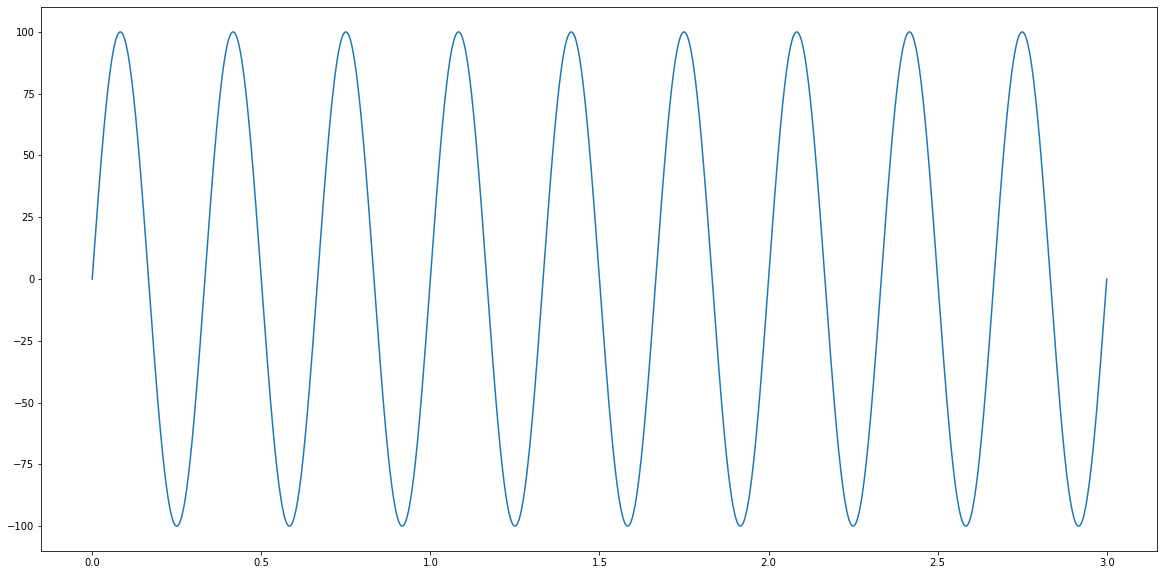

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(x,y)

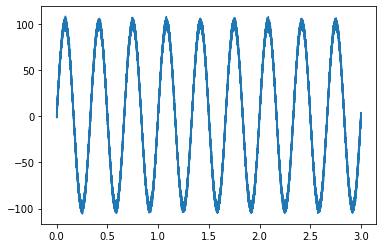

In [21]:
sample_rate = 44100
frequency = 3
amplitude = 100
duration_in_seconds = 3
x, y = sine_wave_noisy(sample_rate, duration_in_seconds, frequency, amplitude, 1, 2.0)
plt.plot(x,y)

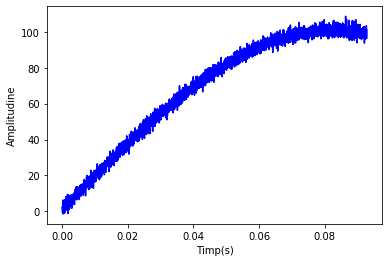

In [22]:
plt.plot(x[:4096], y[:4096], c='b')
plt.xlabel('Timp(s)')
plt.ylabel('Amplitudine')
plt.savefig('sine_wave_noisy.png')

### Statistical tests

To do: add more statistical tests.

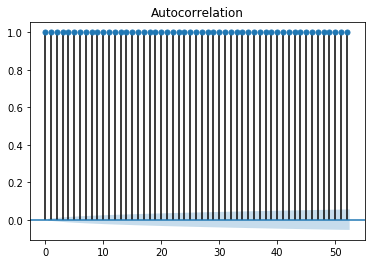

In [11]:
plot_acf(y)
plt.show()

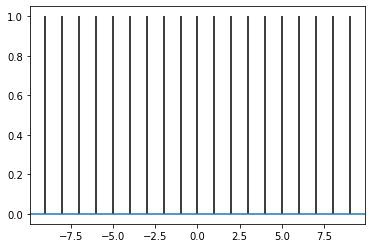

In [12]:
plt.acorr(y, maxlags=9)
plt.show()

### Data preparation

Extract the last 1024 samples from the data as there will be the need to predict at most 1024 samples at a time. No other data preparation is needed for as a sine wave has fixed mean and variance over time, thus it does not have a trend component, and it's not either seasonal.

In [13]:
train, test = y[1:len(x) - 16384], y[len(x)-16384:]

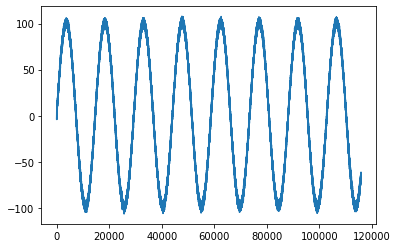

In [14]:
plt.plot(train)

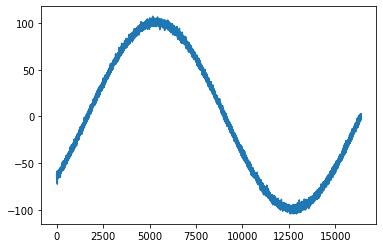

In [15]:
plt.plot(test)

In [16]:
print(f'Train data shape: {train.shape}\nTest data shape:{test.shape}')

Train data shape: (115915,)
Test data shape:(16384,)


### Predictors

#### Persistence model

In [17]:
history = [x for x in train]
predictions = list()

In [18]:
for i in range(len(test)):
    predictions.append(history[-1])
    history.append(test[i])

##### Metrics

In [19]:
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Mean absolute error: {mae}\nRoot mean squared error: {rmse}')

Mean absolute error: 2.2559766528082323
Root mean squared error: 2.824002423624596


##### Plots

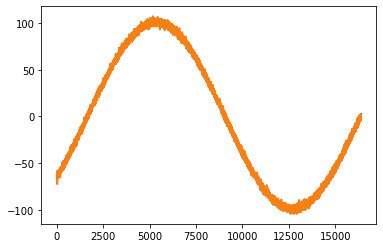

In [20]:
plt.plot(test)
plt.plot(predictions)
plt.show()

As expected, the persistence model yields good results. However, this kind of model could not be used in practice because it requires the data that needs to be predicted, even if at one step at a time.

#### Autoregression

Helper functions.

In [21]:
def get_predictions_and_model(desired_model, train, test):
    model = desired_model(train)
    start = timer()
    fitted_model = model.fit()
    end = timer()
    fit_time = end - start
    start = timer()
    predictions = fitted_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic = False)
    end = timer()
    prediction_time = end - start
    return predictions, fitted_model, prediction_time, fit_time 

In [22]:
def test_predictions(predictions, test):
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    print(f'Mean absolute error: {mae}\nRoot mean squared error: {rmse}')
    fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(8, 4))
    ax[0].set_title('Actual')
    ax[0].plot(test, c='blue')
    ax[0].set_ylabel('Amplitude')
    ax[0].set_xlabel('Time')
    ax[1].set_title('Predicted')
    ax[1].set_ylabel('Amplitude')
    ax[1].set_xlabel('Time')
    ax[1].plot(predictions, c='orange')
    fig.tight_layout()
    plt.show()
    return mae, mse, rmse

In [23]:
def test_last_n_samples(frequency, samples_count:list, x, y):
    out_data = []
    for sample_count in samples_count:
        #print(f'Test for the last {sample_count} samples.')
        train, test = y[1:len(y) - sample_count], y[len(y)-sample_count:]
        predictions, fitted_model, prediction_time, fit_time = get_predictions_and_model(AR, train, test)
        #print(f'Lag: {fitted_model.k_ar}')
        mae, mse, rmse = test_predictions(predictions, test)
        out_data.append([frequency, sample_count, fit_time, prediction_time, mae, mse, rmse])
    return out_data

In [24]:
def test_last_n_samples_freq_amp(freq, amp, samples_count:list, x, y):
    out_data = []
    for sample_count in samples_count:
        #print(f'Test for the last {sample_count} samples.')
        train, test = y[1:len(x) - sample_count], y[len(x)-sample_count:]
        predictions, fitted_model, prediction_time, fit_time = get_predictions_and_model(AR, train, test)
        #print(f'Lag: {fitted_model.k_ar}')
        mae, mse, rmse = test_predictions(predictions, test)
        out_data.append([freq, amp, sample_count, fit_time, prediction_time, mae, mse, rmse])
    return out_data

In [25]:
def test_different_frequencies_waves(sample_rate, duration_in_seconds, frequencies:list, amplitude, samples_count:list):
    data = sine_wave_different_frequencies(sample_rate, duration_in_seconds, frequencies, amplitude)
    out_data = []
    for index, (x,y) in enumerate(data):
        #print(f'Frequency: {frequencies[index]}')
        frequency_data = test_last_n_samples(frequencies[index], samples_count, x, y)
        for single_array in frequency_data:
            out_data.append(single_array)
    return out_data

In [26]:
def test_different_amplitudes_waves(sample_rate, duration_in_seconds, frequency, amplitudes: list, samples_count:list):
    print(amplitudes)
    data = sine_wave_different_amplitudes(sample_rate, duration_in_seconds, frequency, amplitudes)
    out_data = []
    for index, (x,y) in enumerate(data):
        print(f'Amplitude: {amplitudes[index]}')
        amplitude_data = test_last_n_samples(amplitudes[index], samples_count, x, y)
        for single_array in amplitude_data:
            out_data.append(single_array)
    return out_data

In [27]:
def test_different_frequencies_waves_with_noise(sample_rate, duration_in_seconds, loc, scale, frequencies:list, amplitude, samples_count:list):
    data = sine_wave_different_frequencies_with_noise(sample_rate, duration_in_seconds, frequencies, amplitude, loc, scale)
    out_data = []
    for index, (x,y) in enumerate(data):
        print(f'Frequency: {frequencies[index]}')
        frequency_data = test_last_n_samples(frequencies[index], samples_count, x, y)
        for single_array in frequency_data:
            out_data.append(single_array)
    return out_data

In [28]:
def test_different_frequencies_waves_with_noise_freq_amp(sample_rate, duration_in_seconds, loc, scale, frequencies:list, amplitudes:list, samples_count:list):
    data = sine_wave_different_freq_amp_with_noise(sample_rate, duration_in_seconds, frequencies, amplitudes, loc, scale)
    print(len(data))
    out_data = []
    for inner_data in data:
        x, y, freq, amp = inner_data
        #print(f'Frequency :{freq}, Amplitude: {amp}')
        freq_amp_data = test_last_n_samples_freq_amp(freq, amp, samples_count, x, y)
        for single_array in freq_amp_data:
            out_data.append(single_array)
    return out_data

In [29]:
def test_different_freq_amp_waves(sample_rate, duration, frequencies:list, amplitudes: list, samples_count: list):
    data = sine_wave_different_freq_amp(sample_rate, duration, frequencies, amplitudes)
    out_data = []
    for inner_data in data:
        x, y, freq, amp = inner_data
        #print(f'Frequency :{freq}, Amplitude: {amp}')
        freq_amp_data = test_last_n_samples_freq_amp(freq, amp, samples_count, x, y)
        for single_array in freq_amp_data:
            out_data.append(single_array)
    return out_data

Mean absolute error: 0.1987076746341962
Root mean squared error: 0.2519965349576813


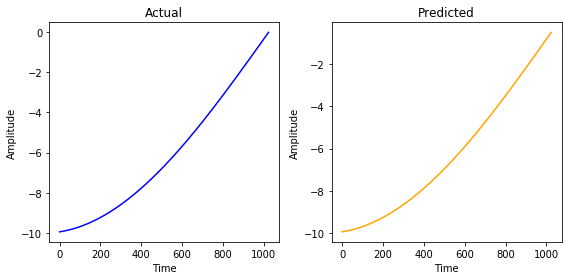

Mean absolute error: 0.6872601095896331
Root mean squared error: 0.8721190171327168


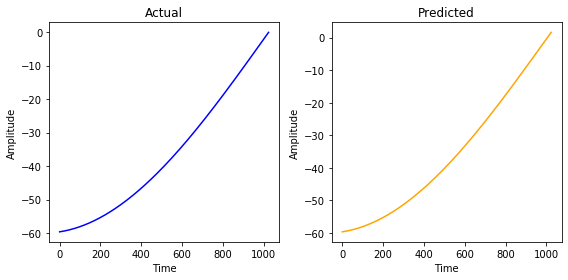

In [32]:
out_data  = test_different_freq_amp_waves(44100, 3,range(10, 101, 100), range(10, 101, 50), [1024])

In [33]:
out_data

[[10,
  10,
  1024,
  2.1093282000001636,
  0.011592500000006112,
  0.1987076746341962,
  0.06350225363067791,
  0.2519965349576813],
 [10,
  60,
  1024,
  1.9663871999991898,
  0.012533499999335618,
  0.6872601095896331,
  0.760591580044536,
  0.8721190171327168]]

In [65]:
out_data

[[10,
  1024,
  1.8911648999992394,
  0.013835800000379095,
  0.1987076746341962,
  0.06350225363067791,
  0.2519965349576813],
 [20,
  1024,
  1.8439869000003455,
  0.012240799999744922,
  2.9918494479962185,
  14.397170856025719,
  3.7943604014412915],
 [30,
  1024,
  1.926947900000414,
  0.011698600000272563,
  0.2093134507603266,
  0.07117022115789089,
  0.2667774749822235],
 [40,
  1024,
  1.7892492000000857,
  0.011337700000694895,
  0.6988979017828182,
  0.7591037264836693,
  0.8712655889472907],
 [50,
  1024,
  1.9845727000001716,
  0.011445000000094296,
  0.20065596416653436,
  0.06819445238754514,
  0.26114067547501124],
 [60,
  1024,
  1.8401295000003302,
  0.011398499999813794,
  0.6425428166238327,
  0.6365964720610906,
  0.7978699593674966],
 [70,
  1024,
  1.7755722000001697,
  0.011726099999577855,
  0.029910860728931548,
  0.00138811339030435,
  0.0372573937669337],
 [80,
  1024,
  1.8525282999999035,
  0.011361400000168942,
  0.37906049934765107,
  0.22280274712704287

In [255]:
column_names =  ['Frequency', 'Amplitude', 'Predicted samples', 'Mean absolute error', 'Root mean square error']
df = pd.DataFrame(out_data, columns = column_names)

df[:50]


Frequency  Amplitude  Predicted samples  Mean absolute error  \
0         100        100               1024             1.575808   
1         100        125               1024             1.778998   
2         100        150               1024             1.564317   
3         100        175               1024             1.579359   
4         100        200               1024             1.697104   
5         100        225               1024             1.603358   
6         100        250               1024             1.677737   
7         100        275               1024             1.649394   
8         100        300               1024             1.699300   
9         100        325               1024             1.626948   
10        100        350               1024             1.671465   
11        100        375               1024             2.094995   
12        100        400               1024             1.634690   
13        100        425               1024             1.697240   
14        100        450               1024             2.034101   
15        100        475               1024             1.624050   
16        100        500               1024             1.975196   
17        100        525               1024             1.982812   
18        100        550               1024             1.760609   
19        100        575               1024             1.559398   
20        100        600               1024             1.701843   
21        100        625               1024             1.799941   
22        100        650               1024             1.857142   
23        100        675               1024             1.756456   
24        100        700               1024             1.804423   
25        100        725               1024             1.675359   
26        100        750               1024             2.375865   
27        100        775               1024             1.647087   
28        100        800               1024             1.892122   
29        100        825               1024             1.752366   
30        100        850               1024             1.678532   
31        100        875               1024             1.681884   
32        100        900               1024             1.661403   
33        100        925               1024             1.634004   
34        100        950               1024             1.677284   
35        100        975               1024             1.689255   
36        100       1000               1024             1.546968   
37        125        100               1024             1.583234   
38        125        125               1024             1.792752   
39        125        150               1024             1.652759   
40        125        175               1024             1.646726   
41        125        200               1024             1.601053   
42        125        225               1024             1.562154   
43        125        250               1024             1.679943   
44        125        275               1024             1.695674   
45        125        300               1024             1.723169   
46        125        325               1024             1.575585   
47        125        350               1024             1.638674   
48        125        375               1024             1.676032   
49        125        400               1024             1.575418   

    Root mean square error  
0                 1.971956  
1                 2.207082  
2                 1.986754  
3                 1.984249  
4                 2.129824  
5                 2.015731  
6                 2.110077  
7                 2.074828  
8                 2.104066  
9                 2.048223  
10                2.113902  
11                2.561238  
12                2.033333  
13                2.117994  
14                2.474736  
15                2.061059  
16                2.437795  
17           

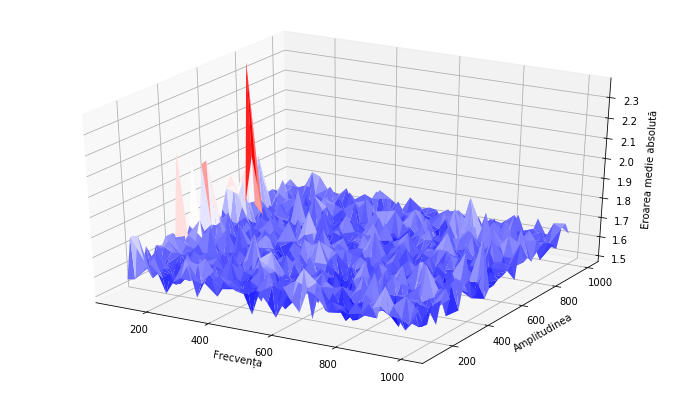

In [257]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 7

X = np.array(df['Frequency'])
Y = np.array(df['Amplitude'])
Z = np.array(df['Mean absolute error'])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(xlabel='Frecvența', ylabel = 'Amplitudinea', zlabel='Eroarea medie absolută')
tr = ax.plot_trisurf(X, Y, Z, cmap='bwr', antialiased=True)


#ax.scatter(X, Y, Z, c=Z, cmap='BrBG', linewidth=1)
plt.savefig('error_3d_more_data_noisy.png')

In [237]:
np.mean(np.arange(100, 1001, 100))

550.0

In [238]:
len(out_data)
#len(out_data[0])

1369

It seems that the model does really good job. What if we generate another one with a wider range of amplitude values?

range(100, 1001, 100)
Amplitude: 100
Mean absolute error: 0.859143469588461
Root mean squared error: 1.079245657138408


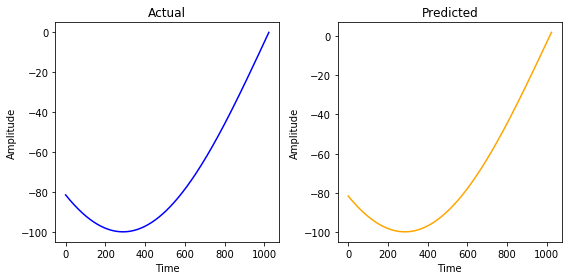

Amplitude: 200
Mean absolute error: 4.431767344583374
Root mean squared error: 5.615027518552682


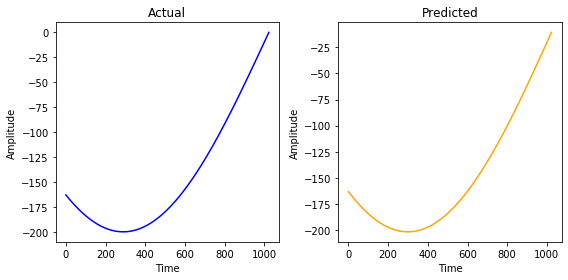

Amplitude: 300
Mean absolute error: 6.094761437770655
Root mean squared error: 7.582755121609625


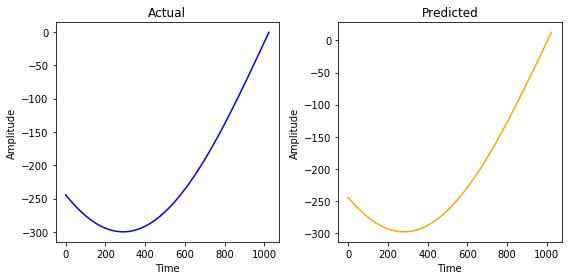

Amplitude: 400
Mean absolute error: 12.111425031781803
Root mean squared error: 15.341269179263769


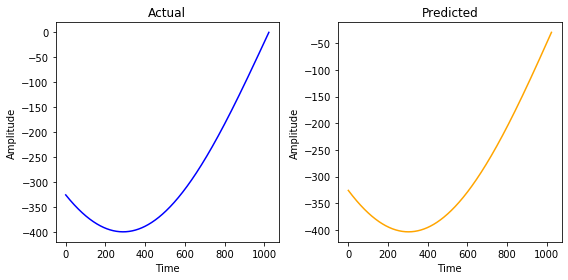

Amplitude: 500
Mean absolute error: 43.16454591574611
Root mean squared error: 54.56301237207698


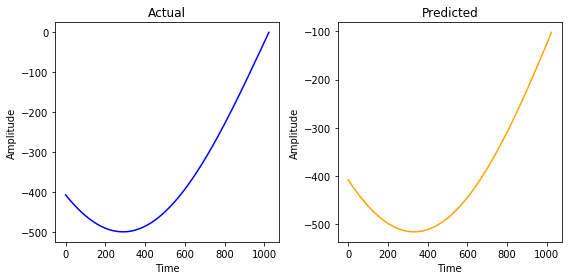

Amplitude: 600
Mean absolute error: 10.716308684853932
Root mean squared error: 13.30147353987752


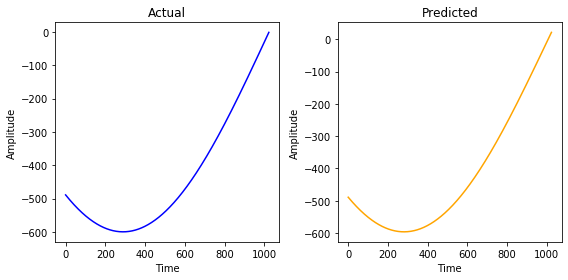

Amplitude: 700
Mean absolute error: 13.658722331337547
Root mean squared error: 16.9515057344364


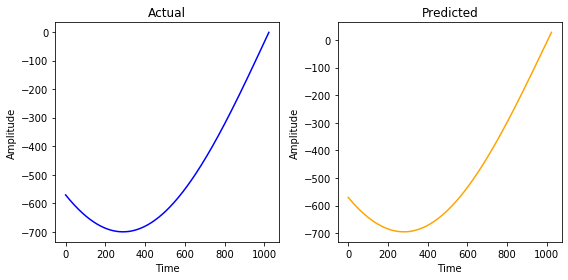

Amplitude: 800
Mean absolute error: 26.67500621992964
Root mean squared error: 33.460219301925356


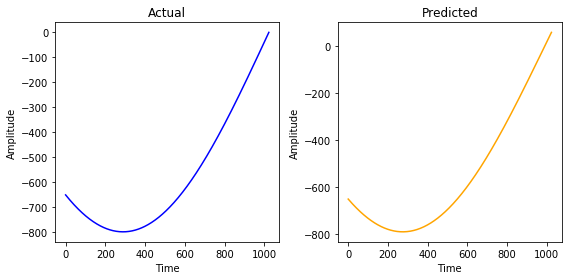

Amplitude: 900
Mean absolute error: 12.821864269885817
Root mean squared error: 16.329907117608666


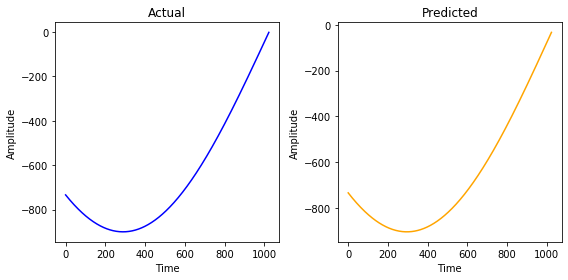

Amplitude: 1000
Mean absolute error: 39.08733899897203
Root mean squared error: 49.220256492829755


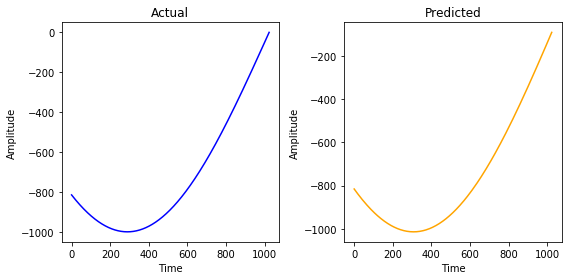

In [239]:
out_data  = test_different_amplitudes_waves(44100, 3, 15, range(100, 1001, 100), [1024])

In [240]:
out_data

[[100, 1024, 0.859143469588461, 1.079245657138408],
 [200, 1024, 4.431767344583374, 5.615027518552682],
 [300, 1024, 6.094761437770655, 7.582755121609625],
 [400, 1024, 12.111425031781803, 15.341269179263769],
 [500, 1024, 43.16454591574611, 54.56301237207698],
 [600, 1024, 10.716308684853932, 13.30147353987752],
 [700, 1024, 13.658722331337547, 16.9515057344364],
 [800, 1024, 26.67500621992964, 33.460219301925356],
 [900, 1024, 12.821864269885817, 16.329907117608666],
 [1000, 1024, 39.08733899897203, 49.220256492829755]]

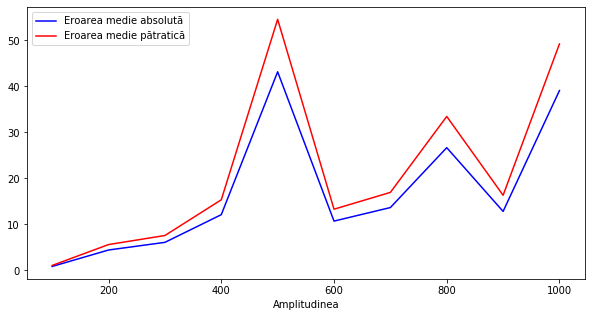

In [241]:
column_names =  ['Amplitude', 'Predicted samples', 'Mean absolute error', 'Root mean square error']
df = pd.DataFrame(out_data, columns = column_names)
df.tail()

df1 = df[df['Predicted samples'] == 1024]
amplitudes = np.array(df1['Amplitude'])
mae  = np.array(df1['Mean absolute error'])
rmse = np.array(df1['Root mean square error'])


fig, ax = plt.subplots(figsize=(10,5),sharex=True, )
ax.plot(amplitudes, mae,'b', label='Eroarea medie absolută')
ax.plot(amplitudes, rmse, 'r', label='Eroarea medie pătratică')
ax.set(xlabel='Amplitudinea')
ax.legend()
plt.savefig('sine_errors_autoregression.png')

In [ ]:
df

In [ ]:
amplitude = 1000
x, y = sine_wave(sample_rate, duration_in_seconds, 3, amplitude)
plt.figure(figsize=(20, 10))
plt.plot(x,y)

In [ ]:
test_last_n_samples(frequency ,[1024, 2048, 8192], x, y)o

What if we add some noise to the signal?

In [ ]:
x, y = sine_wave_noisy(sample_rate, duration_in_seconds, frequency, amplitude, 0, 0.7)

In [ ]:
test_different_frequencies_waves_with_noise(44100, 3, 0, 0.7, range(10, 100, 10), 15, [1024, 2048, 4096, 8192, 16134])

In [ ]:
column_names =  ['Frequency', 'Predicted samples', 'Mean absolute error', 'Root mean square error']
df = pd.DataFrame(out_data, columns = column_names)
df.tail()

In [ ]:
df1 = df[df['Predicted samples'] == 1024]
frequencies = np.array(df1['Frequency'])
mae  = np.array(df1['Mean absolute error'])
rmse = np.array(df1['Root mean square error'])
print(frequencies)
plt.xlabel("Frecvența semnalului")
plt.ylabel("Eroarea medie absolută")
plt.plot(frequencies, mae)


In [ ]:
fig, ax = plt.subplots(figsize=(10,5),sharex=True, )
ax.plot(frequencies, mae,'b', label='Eroarea medie absolută')
ax.plot(frequencies, rmse, 'r', label='Eroarea medie pătratică')
ax.set(xlabel='Frecvența (Hz)')
ax.legend()
plt.savefig('sine_errors_autoregression.png')

In [ ]:
dataframe[dataframe['Percentage'] > 80] 

So far, we can observe the following:
- drastic changes in amplitude do not affect the performance of the AR estimator
- increses in frequency however do affect its performance, as we can see from the metrics and the plots.

Having the test data, we can conclude that the AR model is a sufficiently performant one. Its performance is slightly decreased when increasing the frequency of the signal, but it still produces decent results. Thus, we will stop here with model testing and move on to the next signal.

## Sine sum

This time we're trying to predict a sine sum signal, which would be the next step in terms of signal complexity.

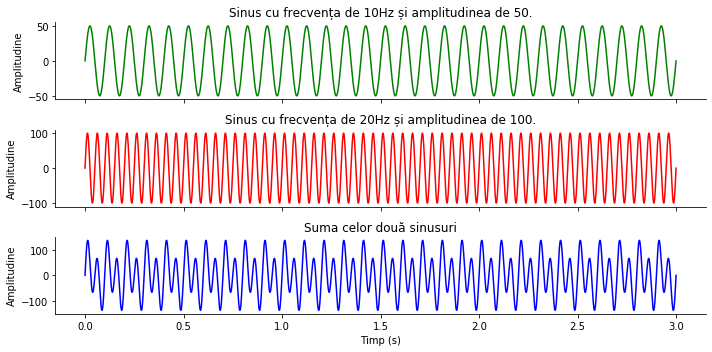

In [22]:
frequency1 = 10
amplitude1 = 50
frequency2 = 20
amplitude2 = 100
x,y, sine1, sine2 = sine_sum(3, sample_rate, frequency1, amplitude1, frequency2, amplitude2)

fig, ax = plt.subplots(nrows = 3, sharex=True, figsize=(10, 5))
ax[0].set_title(f'Sinus cu frecvența de {frequency1}Hz și amplitudinea de {amplitude1}.')
ax[0].plot(x, sine1, c='g')
ax[0].set_ylabel('Amplitudine')
ax[1].plot(x, sine2, c='red')
ax[1].set_ylabel('Amplitudine')
ax[1].set_title(f'Sinus cu frecvența de {frequency2}Hz și amplitudinea de {amplitude2}.')
ax[2].plot(x, y, c = 'blue')
ax[2].set_ylabel('Amplitudine')
ax[2].set_xlabel('Timp (s)')
ax[2].set_title(f'Suma celor două sinusuri')
spines = ['right', 'top']

for current_ax in ax:
    for portion in spines:
        current_ax.spines[portion].set_visible(False)
        

fig.tight_layout()
plt.show()
fig.savefig('sine_sum.png')
    
# plt.figure(figsize=(20,10))
# plt.xlabel('Timp(s)')
# plt.ylabel('Amplitudine')
# plt.plot(x,y, c='b')

### Statistical tests

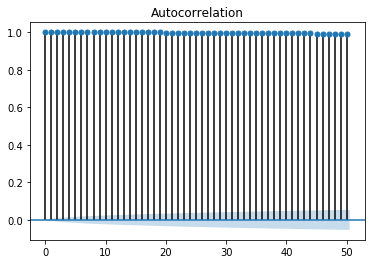

<Figure size 432x288 with 0 Axes>

In [35]:
plot_acf(y, lags=50)
plt.show()
plt.savefig('si')

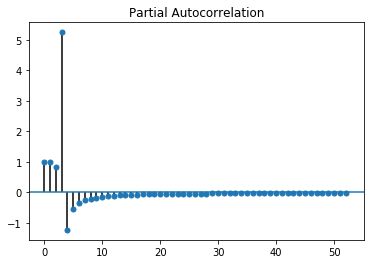

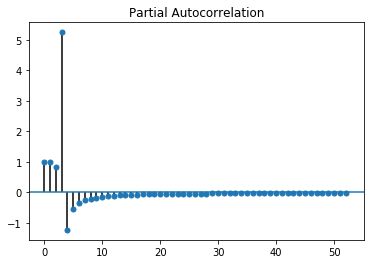

In [30]:
plot_pacf(y, method='ld')

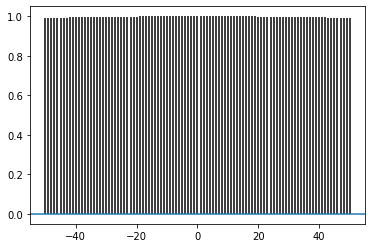

In [12]:
plt.acorr(y, maxlags=50)
plt.show()

### Data preparation

In [13]:
train, test = y[1:len(x) - 1024], y[len(x) - 1024:]

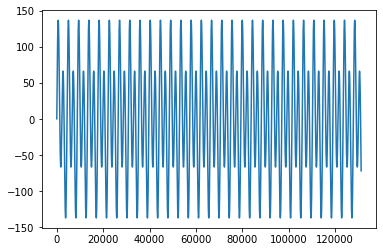

In [14]:
plt.plot(train)

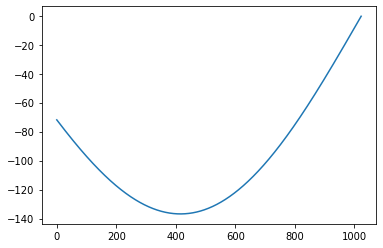

In [15]:
plt.plot(test)

### Predictors

#### Autoregression

Y(t) = C + theta^2 * Y(t-1) + theta*Y(t-2)
Y(t) = C+ theta^n * Y(t-1) + .... theta^1*Y(t-n)

UDP - simulez cu random
Client - deschizi un fisier / trimiti sinus/suma de sinusuri/sweep
Server - dash - real time semnalul, sa dai play, la final sa poti sa dai scroll, 
Websockets
Http request
Producer consumer 
gRPC - 
TCP - simulez pierderea pachetelor cu un random?

------- --

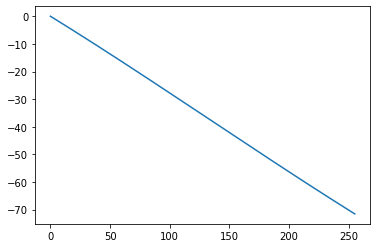

In [21]:
samples_used = 256
plt.plot(train[-samples_used:])

Lag: 72
Coefficients: [ 1.60982339e-15  3.26471210e-01  2.66358376e-01  1.92831039e-01
  1.34532928e-01  2.48920441e-01 -1.35312080e-02 -2.94380188e-02
  3.57077122e-02  4.78234291e-02  1.42658949e-01 -1.21379495e-02
 -2.08168030e-02 -4.94382381e-02 -2.87046432e-02  4.22039032e-02
  1.10006332e-02  6.41155243e-02 -4.06451225e-02 -1.02434635e-01
 -9.39002037e-02 -1.00866079e-01 -1.67722702e-02 -7.91645050e-03
 -3.26743126e-02 -4.61964607e-02 -1.75404549e-02 -2.18772888e-02
  2.78654099e-02  2.90489197e-02 -6.05859756e-02  9.28497314e-03
 -3.56693268e-02  1.01849079e-01  2.40918636e-01  5.00307083e-02
  5.94158173e-02 -4.64019775e-02 -3.62372398e-02  8.79058838e-02
 -1.81502819e-01 -1.72241211e-01 -1.57757759e-01 -1.02595329e-01
  1.39221191e-01 -6.82501793e-02 -7.69858360e-02 -4.88953590e-02
 -5.08809090e-02  9.39385891e-02 -6.97970390e-03  5.02986908e-02
  9.12511349e-02  4.59322929e-02  4.93588448e-02 -5.20764589e-02
  2.27098465e-02  1.41339302e-02  4.65059280e-02  6.00214005e-02
  3

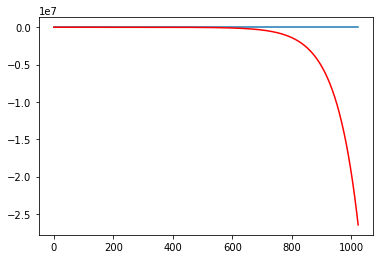

In [19]:
model = AR(train)
fitted_model = model.fit()
print('Lag: %s' % fitted_model.k_ar)
print('Coefficients: %s' % fitted_model.params)
predictions = fitted_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic = False)
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print('Test MAE: %.3f ' % mae)
print('Test RMSE: %.3f' % rmse)
plt.plot(test)
plt.plot(predictions, c = 'red')
plt.show()
plt.savefig('')

In [65]:
def test_last_n_samples(freq1, freq2, samples_count:list, x, y):
    out_data = []
    for sample_count in samples_count:
        print(f'Test for the last {sample_count} samples.')
        train, test = y[1:len(x) - sample_count], y[len(x)-sample_count:]
        predictions, fitted_model = get_predictions_and_model(AR, train, test)
        print(f'Lag: {fitted_model.k_ar}')
        mae, rmse = test_predictions(predictions, test)
        out_data.append([freq1, sample_count, mae, rmse])
    return out_data

Test for the last 1024 samples.
Lag: 72
Mean absolute error: 1971497.3385428654
Root mean squared error: 5126021.552515845


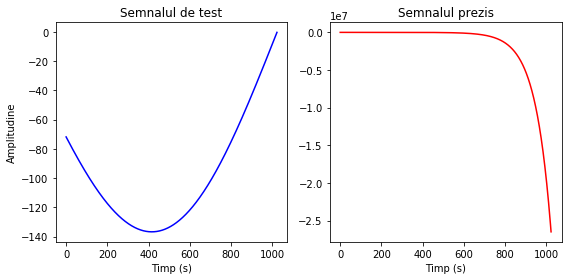

[[10, 1024, 1971497.3385428654, 5126021.552515845]]

In [66]:
test_last_n_samples(frequency1, frequency2, [1024], x, y)

In [72]:
def test_last_n_samples_freq_amp(fr1, am1, fr2, am2, samples_count:list, x, y):
    out_data = []
    for sample_count in samples_count:
        #print(f'Test for the last {sample_count} samples.')
        train, test = y[1:len(x) - sample_count], y[len(x)-sample_count:]
        predictions, fitted_model = get_predictions_and_model(AR, train, test)
        #print(f'Lag: {fitted_model.k_ar}')
        mae, rmse = test_predictions(predictions, test)
        out_data.append([fr1, am1, fr2, am2, sample_count, mae, rmse])
    return out_data

In [73]:
def test_different_freq_amp_waves(sample_rate, duration, samples_count, freq1:list, amp1:list, freq2:list, amp2:list):
    data = sine_sum_different_freq_amp(sample_rate, duration, freq1, amp1, freq2, amp2)
    out_data = []
    for inner_data in data:
        x, y, fr1, am1, fr2, am2 = inner_data
        freq_amp_data = test_last_n_samples_freq_amp(fr1, am1, fr2, am2, samples_count, x, y)
        for single_array in freq_amp_data:
            out_data.append(single_array)
    return out_data

Mean absolute error: 21.572268809848506
Root mean squared error: 26.583159540275503


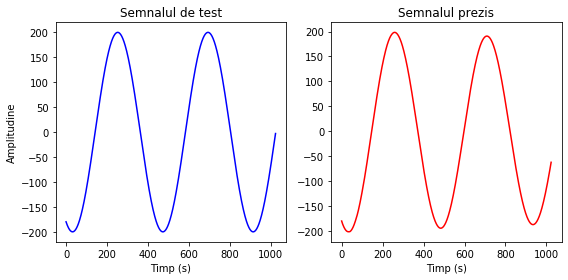

Mean absolute error: 192.6833405516345
Root mean squared error: 235.35784485359625


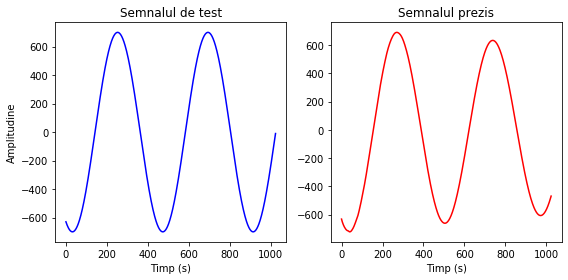

Mean absolute error: 192.6833405516345
Root mean squared error: 235.35784485359625


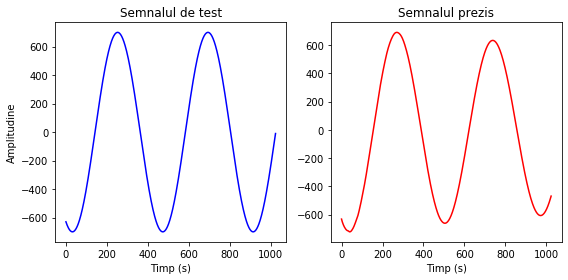

Mean absolute error: 81.18534580064879
Root mean squared error: 101.22154860933985


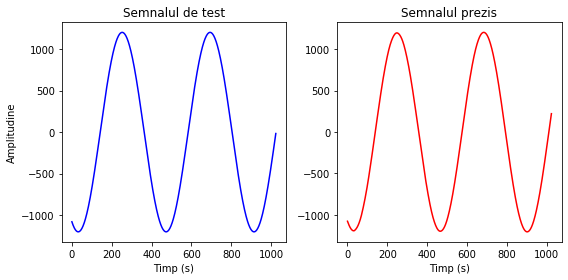

Mean absolute error: 2.743656518917466
Root mean squared error: 3.476009289819673


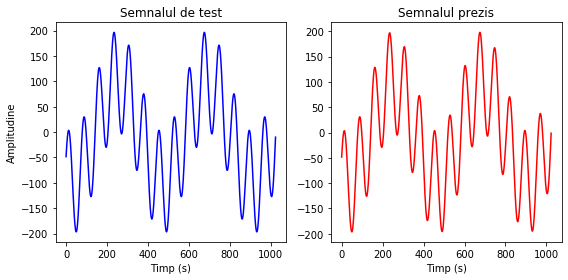

Mean absolute error: 5.107477310446683
Root mean squared error: 6.576536843365106


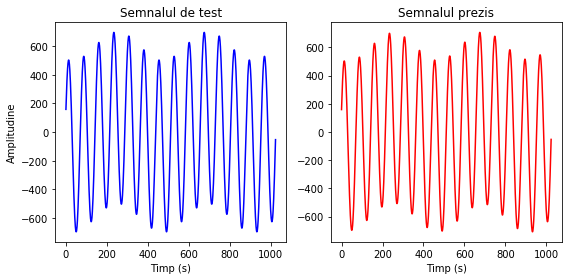

Mean absolute error: 80.15301302705245
Root mean squared error: 100.09167135194043


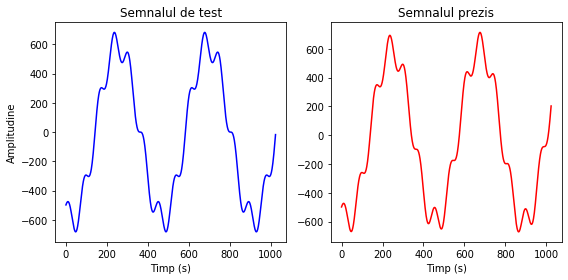

Mean absolute error: 12.670839003249975
Root mean squared error: 16.787659060303938


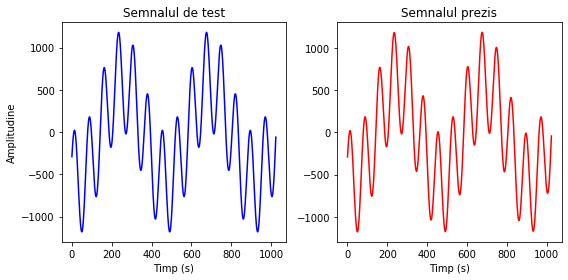

In [ ]:
test_range = range(100, 1001, 25)
sample_rate = 44100
data = test_different_freq_amp_waves(sample_rate, 3, [1024], test_range, test_range, test_range, test_range)

The plots look like there was something wrong in the function (the original signal looks just like a constant line). Let's try to compare the results my multiple subplots.

In [46]:
def test_predictions(predictions, test):
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f'Mean absolute error: {mae}\nRoot mean squared error: {rmse}')
    fig, ax = plt.subplots(ncols = 2, sharex=True, figsize=(8, 4))
    ax[0].set_title('Actual')
    ax[0].plot(test, c='blue')
    ax[0].set_ylabel('Amplitude')
    ax[0].set_xlabel('Time')
    ax[1].set_title('Predicted')
    ax[1].set_ylabel('Amplitude')
    ax[1].set_xlabel('Time')
    ax[1].plot(predictions, c='orange')
    fig.tight_layout()
    plt.show()
    return mae, rmse

In [47]:
def test_last_n_samples(frequency1, frequency2, samples_count:list, x, y):
    out_data = []
    for sample_count in samples_count:
        print(f'Test for the last {sample_count} samples.')
        train, test = y[1:len(x) - sample_count], y[len(x)-sample_count:]
        predictions, fitted_model = get_predictions_and_model(AR, train, test)
        print(f'Lag: {fitted_model.k_ar}')
        mae, rmse = test_predictions(predictions, test)
        out_data.append([frequency, sample_count, mae, rmse])
    return out_data

As expected, plotting two arrays on the same plot figure was not fortunate because the predictions were falling out of the original signal's range, resulting in a misleading plot. Plotting the two signals, actual and predicted, in separate plots yields better visualization.

Test for the last 1024 samples.
Lag: 72
Mean absolute error: 200129933234.02515
Root mean squared error: 709573401251.0228


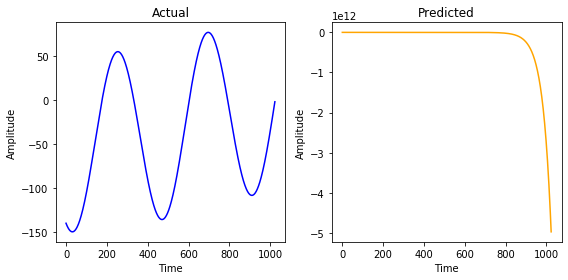

[[3, 1024, 200129933234.02515, 709573401251.0228]]

In [57]:
test_last_n_samples(frequency1, frequency2, [1024], x, y)

Let's try lowering the frequencies.

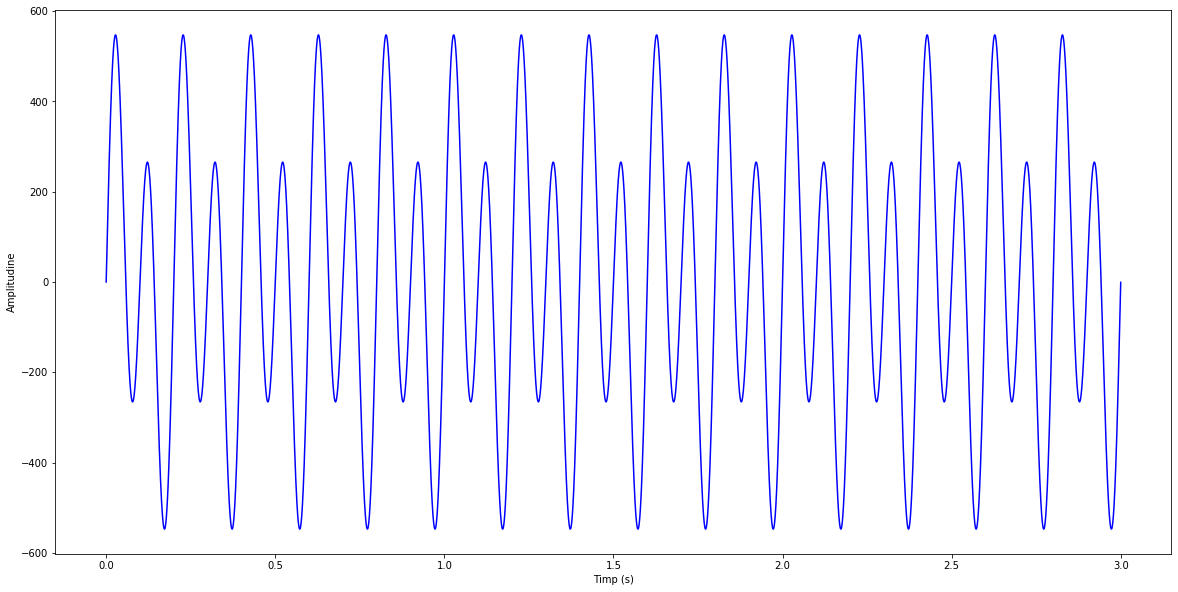

In [75]:
frequency1 = 5
amplitude1 = 200
frequency2 = 10
amplitude2 = 400
x,y = sine_sum(3, sample_rate, frequency1, amplitude1, frequency2, amplitude2)
plt.figure(figsize=(20,10))
plt.xlabel('Timp (s)')
plt.ylabel('Amplitudine')
plt.plot(x, y, c='b')
plt.savefig('sine_sum.png')

Test for the last 1024 samples.
Lag: 72
Mean absolute error: 11544.308204118104
Root mean squared error: 23719.152232330514


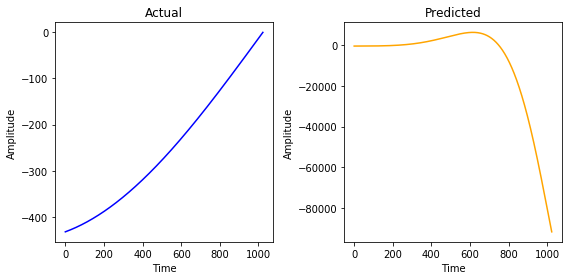

[[3, 1024, 11544.308204118104, 23719.152232330514]]

In [67]:
test_last_n_samples(frequency1, frequency2, [1024], x, y)

It seems that lowering the frequency improves the regressor's accuracy. What about a low and a high frequency?

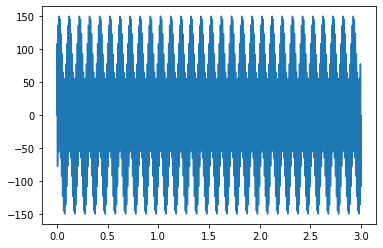

In [51]:
frequency1 = 10
amplitude1 = 50
frequency2 = 100
amplitude2 = 100
x,y = sine_sum(3, sample_rate, frequency1, amplitude1, frequency2, amplitude2)
plt.plot(x, y)

Test for the last 512 samples.
Lag: 72
Mean absolute error: 238287.143695313
Root mean squared error: 571259.0321242149


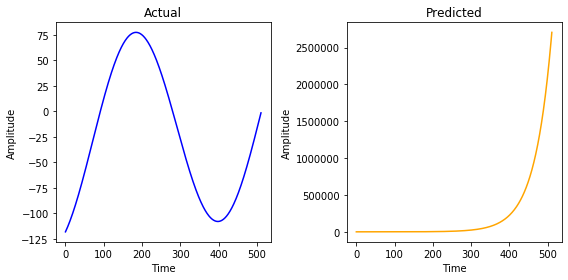

Test for the last 1024 samples.
Lag: 72
Mean absolute error: 200129933234.02515
Root mean squared error: 709573401251.0228


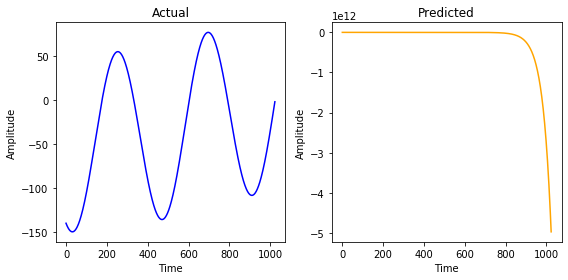

Test for the last 2048 samples.
Lag: 72
Mean absolute error: 2.353124036295429e+19
Root mean squared error: 1.1074739270686532e+20


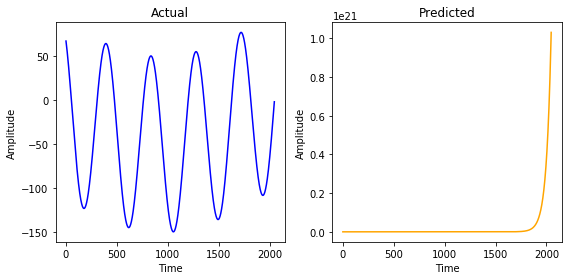

Test for the last 4096 samples.
Lag: 72
Mean absolute error: 1.5780605072765146e+41
Root mean squared error: 1.091524956544359e+42


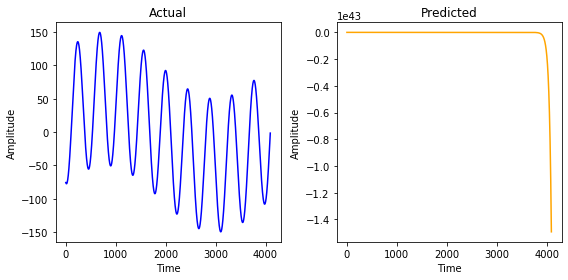

Test for the last 16384 samples.
Lag: 70
Mean absolute error: 6.5533813172615545e+242
Root mean squared error: inf


C:\Users\sill4\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:243: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
C:\Users\sill4\Anaconda3\lib\site-packages\numpy\core\_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


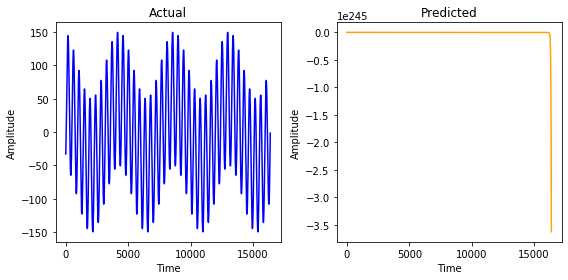

[[3, 512, 238287.143695313, 571259.0321242149],
 [3, 1024, 200129933234.02515, 709573401251.0228],
 [3, 2048, 2.353124036295429e+19, 1.1074739270686532e+20],
 [3, 4096, 1.5780605072765146e+41, 1.091524956544359e+42],
 [3, 16384, 6.5533813172615545e+242, inf]]

In [52]:
test_last_n_samples(frequency1, frequency2, [512, 1024, 2048, 4096, 16384], x, y)

Having these observations, let's try different combinations of frequencies.

In [53]:
def test_last_n_samples(freq1, freq2, samples_count:list, x, y):
    out_data = []
    for sample_count in samples_count:
        print(f'Test for the last {sample_count} samples.')
        train, test = y[1:len(x) - sample_count], y[len(x)-sample_count:]
        predictions, fitted_model = get_predictions_and_model(AR, train, test)
        print(f'Lag: {fitted_model.k_ar}')
        mae, rmse = test_predictions(predictions, test)
        out_data.append([frequency, sample_count, mae, rmse])
    return out_data

In [54]:
def test_different_frequencies_sine_sum_waves(sample_rate, duration_in_seconds, frequencies:list, amp1, amp2, samples_count:list):
    data = sine_sum_different_frequencies(sample_rate, duration_in_seconds, frequencies, amp1, amp2)
    out_data = []
    for index, (x,y) in enumerate(data):
        (freq1, freq2) = frequencies[index]
        print(f'Frequency1: {freq1}, Frequency2: {freq2}')
        frequency_data = test_last_n_samples(freq1, freq2, samples_count, x, y)
        for single_array in frequency_data:
            out_data.append(single_array)
    return out_data

In [55]:
frequencies1 = list(range(10, 101, 10))
frequencies2 = list(range(15, 106, 10))
import itertools
result = list(itertools.product(frequencies1, frequencies2))
result[:5]

[(10, 15), (10, 25), (10, 35), (10, 45), (10, 55)]

Frequency1: 10, Frequency2: 15
Test for the last 1024 samples.
Lag: 72
Mean absolute error: 13697.935665855937
Root mean squared error: 29809.660541142868


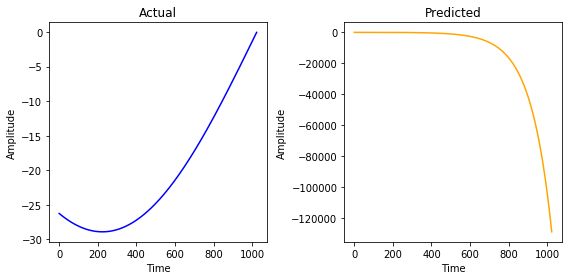

Test for the last 2048 samples.
Lag: 72
Mean absolute error: 1068131.1486552749
Root mean squared error: 2723178.188911902


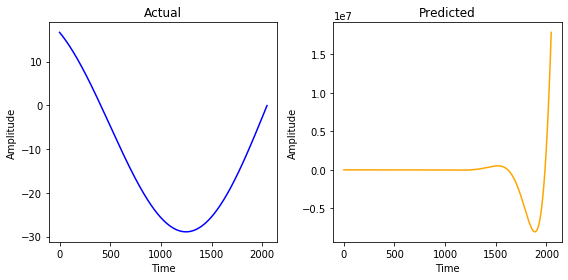

Test for the last 4096 samples.
Lag: 72
Mean absolute error: 2.735476821245267e+18
Root mean squared error: 1.2976473623594869e+19


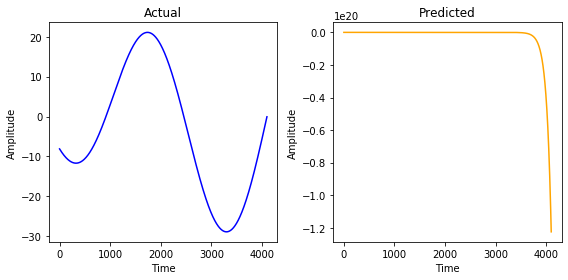

Frequency1: 10, Frequency2: 25
Test for the last 1024 samples.
Lag: 72
Mean absolute error: 195.01081043547111
Root mean squared error: 326.30165411438514


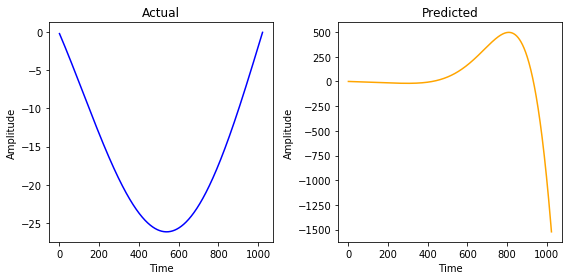

Test for the last 2048 samples.
Lag: 72
Mean absolute error: 1292421.368455839
Root mean squared error: 3935280.4826866607


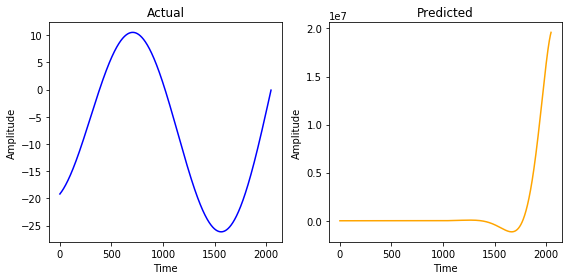

Test for the last 4096 samples.
Lag: 72
Mean absolute error: 409304818.44703287
Root mean squared error: 1360473442.164565


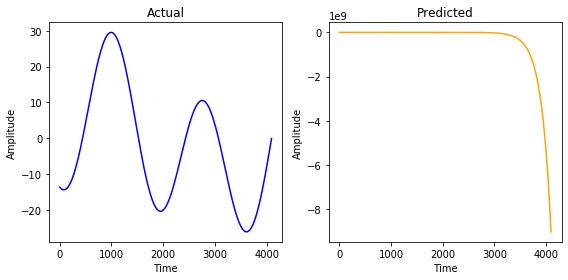

Frequency1: 10, Frequency2: 35
Test for the last 1024 samples.
Lag: 72
Mean absolute error: 1503546.7355705786
Root mean squared error: 4200958.334431356


KeyboardInterrupt: 

In [56]:
test_different_frequencies_sine_sum_waves(sample_rate, 3, result, 10, 20, [1024, 2048, 4096])

#### Simple Exponential Smoothing

In [ ]:
frequency1 = 30
amplitude1 = 50
frequency2 = 60
amplitude2 = 50
x_axis,y_axis = sine_sum(3, sample_rate, frequency1, amplitude1, frequency2, amplitude2)
plt.figure(figsize=(23,13))
plt.plot(x_axis,y_axis)

In [ ]:
train, test = y_axis[1:len(x) - 1024], y_axis[len(x)-1024:]

In [ ]:
plt.plot(train)

In [ ]:
plt.plot(test)

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
y_axis[:11]

In [ ]:
n_steps = 10
# split into samples
X, y = split_sequence(train, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=5, verbose=2)

In [ ]:
# demonstrate prediction
x_input = test[1:11]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

In [ ]:
test[11]